In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch


import data
import train_utils as tutils 
import architectures as archs
from torchvision import transforms as tf
from tqdm import trange

In [2]:
transforms = [lambda x: x]

rotate90 = tf.RandomRotation((90, 90))
rotate180 = tf.RandomRotation((180, 180))
rotate270 = tf.RandomRotation((270, 270))
flipH = tf.RandomHorizontalFlip(p=1.0)

rot90 = tf.Compose([rotate90])
rot180 = tf.Compose([rotate180])
rot270 = tf.Compose([rotate270])
flip = tf.Compose([flipH])
fliprot90 = tf.Compose([flipH, rotate90])
fliprot180 = tf.Compose([flipH, rotate180])
fliprot270 = tf.Compose([flipH, rotate270])

for transform in [rot90, rot180, rot270, flip, fliprot90, fliprot180, fliprot270]:
    transforms.append(transform)

nr_transformations = len(transforms)

In [3]:
def plot_2d_tensor(tensor, title="Image"):
    plt.figure()
    plt.imshow(tensor)
    plt.title(title)
    plt.show()

In [4]:
datapath = "/mn/stornext/d10/data/johanmkr/simulations/data_z1/data_z1.h5"
train_loader, test_loader = data.CUBE_make_training_and_testing_data([0], [1], newton_augmentation=0, datapath=datapath)

Making datasets...
Training set: 1 seeds
Test set: 1 seeds


In [5]:
test_data = data.WholeCubeDataset(seeds=[0,1], newton_augmentation=0.0, datapath=datapath)

In [6]:
sample0 = test_data[0]
sample1 = test_data[1]

In [7]:
cubes = torch.stack([sample0["cube"], sample1["cube"]], dim=0)
labels = torch.stack([sample0["label"], sample1["label"]], dim=0)

In [8]:
labels.shape

torch.Size([2, 1])

In [9]:
def slice_and_rearrange_cube(cubes, labels):
    # Stack together the cubes and labels in the batch
    N, D, H, W = cubes.shape
    
    slices = []
    targets = []
    for i in range(N):
        slice_d = cubes[i, :, :, :].unsqueeze(0).permute(0, 2, 3, 1).reshape(-1, 1, H, W)  # (256, 1, 256, 256)
        slice_h = cubes[i, :, :, :].unsqueeze(0).permute(0, 1, 3, 2).reshape(-1, 1, D, W)  # (256, 1, 256, 256)
        slice_w = cubes[i, :, :, :].unsqueeze(0).reshape(-1, 1, D, H)  # (256, 1, 256, 256)
        slices.append(slice_d)
        slices.append(slice_h)
        slices.append(slice_w)
        
        target = torch.ones(256, 1) * labels[i]
        targets.append(target)
        targets.append(target)
        targets.append(target)
    
    all_slices = torch.cat(slices, dim=0)
    all_targets = torch.cat(targets, dim=0)

    # Old version
    
    # slices_d = cubes.permute(0, 2, 3, 1).reshape(-1, 1, H, W)  # (N*256, 1, 256, 256)
    # slices_h = cubes.permute(0, 1, 3, 2).reshape(-1, 1, D, W)  # (N*256, 1, 256, 256)
    # slices_w = cubes.reshape(-1, 1, D, H)  # (N*256, 1, 256, 256)
    
    
    # all_slices = torch.cat(
    #     [slices_d, slices_h, slices_w], dim=0
    # )  # (3*N*256, 1, 256, 256)

    # all_targets = labels.repeat(1, 256 * 3).reshape(-1, 1)  # (3*N*256, 1)
    
    return all_slices, all_targets

In [10]:
# import time
# start = time.time()
# for _ in range(100):
#     all_slices, targets = slice_and_rearrange_cube(cubes, labels)
# end = time.time()
# print(f"time: {(end - start)/100:.2} s")
all_slices, targets = slice_and_rearrange_cube(cubes, labels)


In [11]:
all_slices.shape

torch.Size([1536, 1, 256, 256])

In [12]:
targets.shape

torch.Size([1536, 1])

In [13]:
print(targets)

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])


In [14]:
# plot_2d_tensor(all_slices[0,0,:,:].numpy(), title="Slice 0")
# plot_2d_tensor(transforms[0](all_slices[0,0,:,:].unsqueeze(0)).squeeze(0), title="Slice 0 transformed")

In [15]:
error_count = 0
transforms_idices = list(np.random.permutation(nr_transformations))
for transform_idx in transforms_idices:
    # Create a permutation index that will be used to shuffle both the slices and the labels.
    permutation_index = torch.randperm(all_slices.size(0))

    # Apply this permutation to shuffle the slices
    all_slices = all_slices[permutation_index]

    # Apply the same permutation to shuffle the labels
    targets = targets[permutation_index]
    transformed_slices = transforms[transform_idx](all_slices)
    for i in trange(all_slices.size(0)):
        mean = all_slices[i].mean()
        if (mean.item() == 0.0 and targets[i].item() != 0) or (targets[i].item() == 0.0 and mean.item() != 0.0):
            error_count += 1
            # print(mean.item(), targets[i].item())
        
#         if mean.item() < 1e-9:
#             if targets[0].item() > 1e-9:
#                 error_count += 1
#                 print(mean.item(), targets[i].item())
print(error_count)

100%|██████████| 1536/1536 [00:00<00:00, 26473.14it/s]


100%|██████████| 1536/1536 [00:00<00:00, 18289.27it/s]

0


AttributeError: 'Figure' object has no attribute 'close'

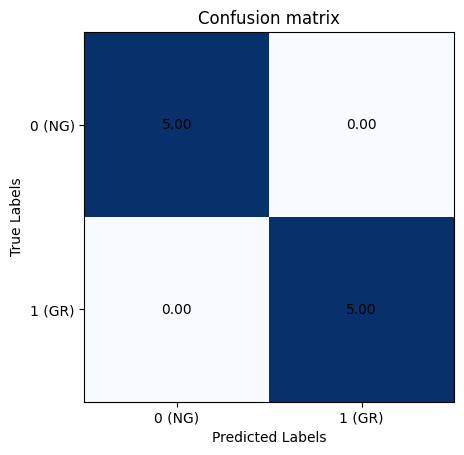

In [17]:
test = [0,0,0,0,1,1,1,1,1,0,1,0,1,0,0,0,0,0,1,1,1,1]
pred = [1,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,1,0,1,0,0,1]

img = tutils.create_confusion_matrix(TP=5, TN=5, FP=0, FN=0, normalize=False)
